Gradient Boosting Models (e.g., XGBoost, LightGBM)

Generalized Additive Models (GAM) 

Support Vector Regression (SVR) 

Convolutional Neural Networks (CNN) 

Recurrent Neural Networks (RNN) 

Long Short-Term Memory Networks (LSTM) 

Transformer-based Models


In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('./solar_weather_processed.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Energy delta[Wh]  196776 non-null  float64
 1   GHI               196776 non-null  float64
 2   temp              196776 non-null  float64
 3   pressure          196776 non-null  float64
 4   humidity          196776 non-null  float64
 5   wind_speed        196776 non-null  float64
 6   rain_1h           196776 non-null  float64
 7   snow_1h           196776 non-null  float64
 8   clouds_all        196776 non-null  float64
 9   isDayTime         196776 non-null  int64  
 10  Year              196776 non-null  int64  
 11  Month_num         196776 non-null  int64  
 12  DayOfYear         196776 non-null  int64  
 13  Minute            196776 non-null  int64  
 14  Hour              196776 non-null  int64  
 15  Hour_sin          196776 non-null  float64
 16  Hour_cos          19

# Seperate file for model buiding only


In [18]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [19]:
# 6. Define X (features) and y (target)
FEATURES = [col for col in df.columns if col != 'Energy delta[Wh]']
X = df[FEATURES]
y = df['Energy delta[Wh]']

In [20]:
# 7. Time-based train-test split (80-20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## Checking feature importance

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

# 1️⃣ Train the XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 2️⃣ Compute Permutation Feature Importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

# 3️⃣ Convert Results to DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# 4️⃣ Display Important Features
print(feature_importance)

# 5️⃣ Drop Low-Importance Features (Example: Keep Features Above 0.001 Importance)
threshold = 0.001  # Adjust based on your results
selected_features = feature_importance[feature_importance["Importance"] > threshold]["Feature"].tolist()

# 6️⃣ Use Selected Features for Training
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


         Feature  Importance
24  Energy_lag_1    0.677571
0            GHI    0.404244
17      Week_cos    0.019930
13          Hour    0.016298
25  Energy_lag_2    0.012857
11     DayOfYear    0.003137
7     clouds_all    0.002597
1           temp    0.001564
9           Year    0.001364
5        rain_1h    0.001198
4     wind_speed    0.001113
15      Hour_cos    0.001036
3       humidity    0.000960
12        Minute    0.000808
2       pressure    0.000585
16      Week_sin    0.000445
22    Season_sin    0.000394
14      Hour_sin    0.000328
18    Minute_sin    0.000127
10     Month_num    0.000071
23    Season_cos    0.000071
19    Minute_cos    0.000039
8      isDayTime    0.000000
6        snow_1h    0.000000
20   Weekday_sin    0.000000
21   Weekday_cos    0.000000


In [22]:
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information scores
mi_scores = mutual_info_regression(X_train, y_train)

# Create DataFrame for easy visualization
mi_scores_df = pd.DataFrame({"Feature": X_train.columns, "Score": mi_scores})
mi_scores_df = mi_scores_df.sort_values(by="Score", ascending=False)

# Select top features based on threshold
selected_features = mi_scores_df[mi_scores_df["Score"] > 0.01]["Feature"].tolist()

X_train_mi = X_train[selected_features]
X_test_mi = X_test[selected_features]

print(f"Selected Features: {selected_features}")


Selected Features: ['Energy_lag_1', 'GHI', 'Energy_lag_2', 'Hour', 'isDayTime', 'Hour_cos', 'humidity', 'Hour_sin', 'temp', 'DayOfYear', 'Week_sin', 'Week_cos', 'Month_num', 'Season_cos', 'clouds_all', 'pressure', 'rain_1h', 'wind_speed']


In [23]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# Normalize data for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM input [samples, time steps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Train LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test)


  9%|==                  | 3507/39356 [00:20<03:24]       

In [ ]:
import shap
import numpy as np
import tensorflow as tf

# Ensure input is a NumPy array (float32 format)
X_test_lstm = np.array(X_test_lstm, dtype=np.float32)

# Use SHAP GradientExplainer instead of DeepExplainer
explainer_lstm = shap.GradientExplainer(lstm_model, X_train_lstm)

# Compute SHAP values correctly
shap_values_lstm = explainer_lstm.shap_values(X_test_lstm)

# Summary Plot
shap.summary_plot(shap_values_lstm[0], X_test_lstm)  # Use [0] for first output if multi-output


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost Feature Importance
shap.summary_plot(shap_values_xgb, X_test, show=False)
axes[0].set_title("XGBoost SHAP Feature Importance")

# LSTM Feature Importance
shap.summary_plot(shap_values_lstm, X_test, show=False)
axes[1].set_title("LSTM SHAP Feature Importance")

plt.tight_layout()
plt.show()


In [ ]:
## Now we selected some high importance feautures to train the model

## Models

### XGboost, ligbtGBM

MAE: 0.01977369171926068
RMSE: 0.04993535928348696


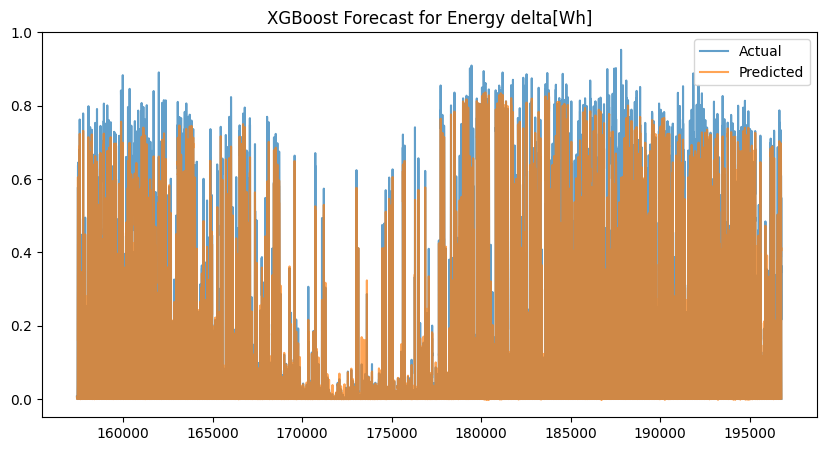

In [33]:
# 8. Train XGBoost
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=False)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("XGBoost Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.112938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

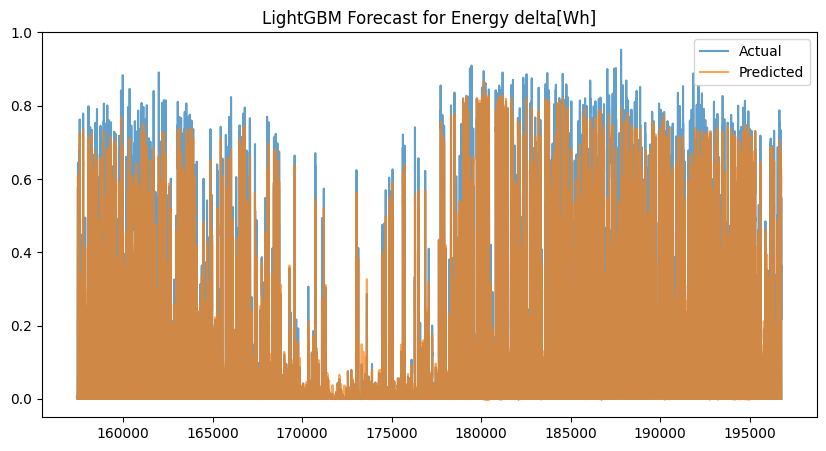

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)])  # Corrected parameter

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.112938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

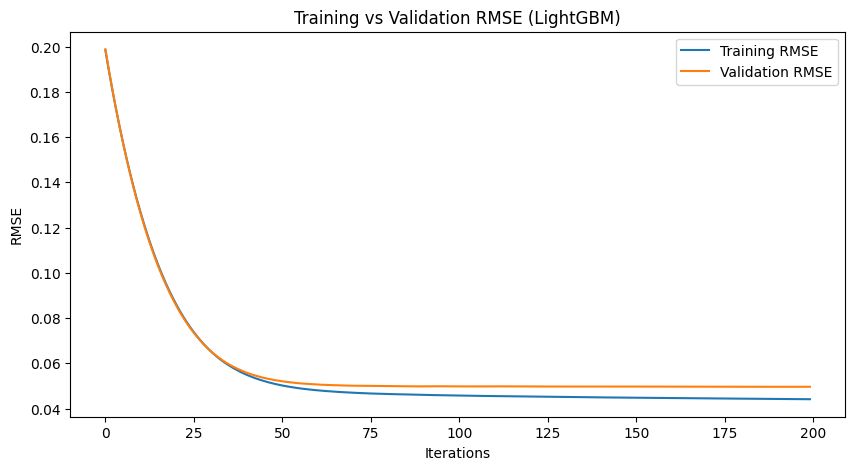

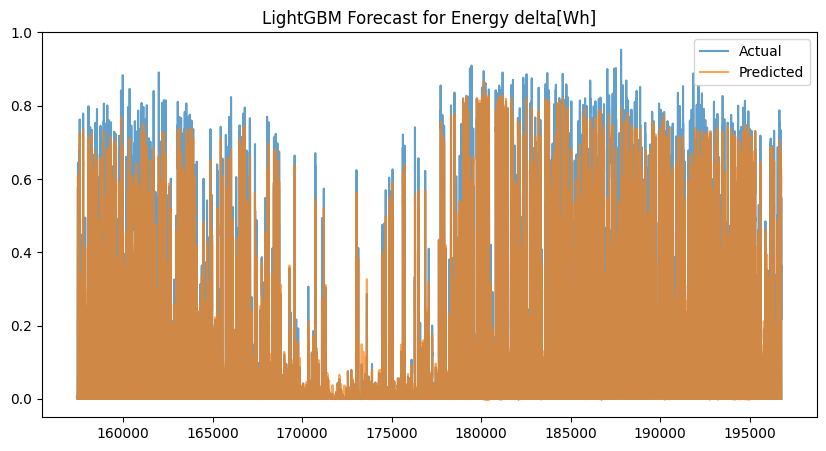

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, early_stopping, record_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM with monitoring
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

evals_result = {}  # Dictionary to store training history

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",  # Use RMSE for evaluation
    callbacks=[record_evaluation(evals_result)]  # ✅ Fix: Store training history
)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot Training Curve (to check overfitting)
plt.figure(figsize=(10, 5))
plt.plot(evals_result["training"]["rmse"], label="Training RMSE")  # ✅ Fix: "training" is now recorded
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE (LightGBM)")
plt.legend()
plt.show()

# 12. Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


### GAM

In [34]:
import pandas as pd
from pygam import LinearGAM, s

In [35]:

# Define GAM model with smooth terms for each feature
from pygam import LinearGAM, s

# Define GAM model with smooth terms for each feature
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + 
    s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + 
    s(16) + s(17) + s(18) + s(19) + s(20) + s(21)
).fit(X, y)

# Print model summary
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    223.9474
Link Function:                     IdentityLink Log Likelihood:                             -17089305.8949
Number of Samples:                       196776 AIC:                                         34179061.6845
                                                AICc:                                        34179062.2017
                                                GCV:                                                0.0055
                                                Scale:                                              0.0055
                                                Pseudo R-Squared:                                   0.8736
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp\ipykernel_14048\1510671690.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test set
y_pred = gam.predict(X_test)

# Compute accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 0.0469
MSE: 0.0062
RMSE: 0.0789
MAPE: inf%


### SVR

In [37]:
from sklearn.svm import SVR


In [ ]:
# 4. Define and Train SVR Model
svr = SVR(kernel='rbf', C=10, epsilon=0.01)  # RBF kernel is good for nonlinear relationships
svr.fit(X_train, y_train)

# 5. Make Predictions
y_pred = svr.predict(X_test)

# 6. Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# 7. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.0775
MSE: 0.0231
RMSE: 0.1519
MAPE: inf%


### CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 3. Normalize Data (CNNs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

# 4. Reshape Data for CNN [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 2/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 3/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 7/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 8/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 9/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 10/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 11/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 12/20
4920/4920 ━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_14048\1712566322.py:53: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100


### LSTM

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 3. Normalize Data (LSTMs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# 4. Reshape Data for LSTM [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
 

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 2/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 3/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 5/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 11/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/20
4920/49

C:\Users\User\AppData\Local\Temp\ipykernel_14048\2860109081.py:62: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100
